### Split dataset into train and validation

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
os.chdir('../../scripts/')
from utils import split_annotations
os.chdir('../experiments/experiment_0/')

In [2]:
annotations_path = '../../data/annotations/annotations.xlsx'
experiment_data_path = 'data/'

In [3]:
# Split the original annotations file into train and validation annotations files
# val_ratio = 0.2 (value by default)
split_annotations(annotations_path, experiment_data_path, test_split=False)

# Read the previous three created .xlsx files into dataframes
train_df = pd.read_excel(f'{experiment_data_path}/train_annotations.xlsx')
val_df = pd.read_excel(f'{experiment_data_path}/val_annotations.xlsx')

len(train_df), len(val_df)

(2800, 700)

### Train the model

In [12]:
!python ../../scripts/train.py -h

usage: train.py [-h] [--random_seed RANDOM_SEED] [--img_size IMG_SIZE]
                [--images_path IMAGES_PATH]
                [--train_annotations_path TRAIN_ANNOTATIONS_PATH]
                [--val_annotations_path VAL_ANNOTATIONS_PATH]
                [--use_annotations_mini] [--batch_size BATCH_SIZE]
                [--num_workers NUM_WORKERS] [--lr LR] [--epochs EPOCHS]
                [--experiment_name EXPERIMENT_NAME] [--extra EXTRA]

Train a network for image multi-label classification on ODIR-5K.

options:
  -h, --help            show this help message and exit
  --random_seed RANDOM_SEED
                        Sets random seed for reproducibility (default: 42).
  --img_size IMG_SIZE   The images will be resized to (img_size, img_size)
                        (default: 224).
  --images_path IMAGES_PATH
                        Path of ODIR training images (default:
                        /kaggle/input/odir-size-512/odir-size-512).
  --train_annotations_path TRAIN_ANNOTAT

In [1]:
# img_size = 224
images_path = '../../data/images/train_224'
train_annotations_path = 'data/train_annotations.xlsx'
val_annotations_path = 'data/val_annotations.xlsx'
batch_size = 32
epochs = 40
# patience = 5
experiment_name = 'experiment_0'

In [2]:
%run ../../scripts/train.py --images_path {images_path} --train_annotations_path {train_annotations_path} --val_annotations_path {val_annotations_path}\
                            --batch_size {batch_size} --epochs {epochs} --experiment_name {experiment_name} --use_normalization

[INFO] Created new resnet50_dual model.
[INFO] Created SummaryWriter, saving to: ..\runs\resnet50_dual\experiment_0...


  0%|          | 0/40 [00:00<?, ?it/s]

Ep: 0 | t_loss: 0.6802 | t_kappa: -0.0180 | t_f1: 0.2944 | t_auc: 0.5169 | t_final: 0.2645 | v_loss: 0.6770 | v_kappa: 0.0970 | v_f1: 0.3205 | v_auc: 0.6228 | v_final: 0.3468
Validation loss decreased (inf --> 0.676973).  Saving model ...
Ep: 1 | t_loss: 0.6687 | t_kappa: -0.0189 | t_f1: 0.2619 | t_auc: 0.4660 | t_final: 0.2363 | v_loss: 0.6634 | v_kappa: 0.0792 | v_f1: 0.2778 | v_auc: 0.5905 | v_final: 0.3158
Validation loss decreased (0.676973 --> 0.663430).  Saving model ...
Ep: 2 | t_loss: 0.6480 | t_kappa: -0.0097 | t_f1: 0.2579 | t_auc: 0.5020 | t_final: 0.2501 | v_loss: 0.6418 | v_kappa: 0.0187 | v_f1: 0.1842 | v_auc: 0.6130 | v_final: 0.2720
Validation loss decreased (0.663430 --> 0.641842).  Saving model ...
Ep: 3 | t_loss: 0.6257 | t_kappa: -0.0145 | t_f1: 0.1660 | t_auc: 0.4778 | t_final: 0.2098 | v_loss: 0.6238 | v_kappa: 0.0769 | v_f1: 0.1368 | v_auc: 0.6217 | v_final: 0.2785
Validation loss decreased (0.641842 --> 0.623820).  Saving model ...
Ep: 4 | t_loss: 0.5958 | t_ka

In [4]:
%load_ext tensorboard
%tensorboard --logdir ../runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 12220), started 1 day, 14:04:46 ago. (Use '!kill 12220' to kill it.)

### Test

In [2]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

os.chdir('../../scripts')
from datasets import ODIRDataset
from utils import load_model
# from ODIR_evaluation import ODIR_Metrics
from metrics import compute_challenge_metrics
os.chdir('../experiments/experiment_0/')

In [3]:
val_annotations_path = 'data/val_annotations.xlsx'
images_path = '../../data/images/train_224'
model_path = 'outputs/resnet50_dual_experiment_0_model.pth'
ground_truth_path = 'outputs/ground_truth.xlsx'
probs_path = 'outputs/probs.csv'

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
model = load_model(model_path)
model.to(device)
model.name

[INFO] Created new resnet50_dual model.


'resnet50_dual'

In [6]:
# Create test transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create test dataset
val_df = pd.read_excel(val_annotations_path)[:30]

val_dataset = ODIRDataset(images_path, val_df, transform)

# Create the ground truth df that will be used as one of the arguments
# when run the offitiol evaluation file (ODIR_evaluation.py)
gt_df = val_df.loc[:, ['ID','N','D','G','C','A','H','M','O']]
gt_df = gt_df.reset_index(drop=True)
gt_df.to_excel(ground_truth_path, index=False)

# Create test dataloader
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=32,
                            num_workers=0,
                            pin_memory=True,
                            shuffle=False)

In [7]:
loss_fn = torch.nn.BCEWithLogitsLoss()

In [8]:
model.eval()

test_loss = 0
all_y = torch.tensor([], dtype=torch.float32).to(device)
all_probs = torch.tensor([], dtype=torch.float32).to(device)

with torch.inference_mode():
    for ((X_left, X_right), y) in val_dataloader:
        X_left, X_right, y = X_left.to(device), X_right.to(device), y.to(device)

        logits = model(X_left, X_right)
        probs = torch.sigmoid(logits)

        loss = loss_fn(logits, y)
        test_loss += loss.item()

        all_y = torch.cat((all_y, y))
        all_probs = torch.cat((all_probs, probs))

all_y = all_y.detach().cpu().numpy()
all_probs = all_probs.detach().cpu().numpy()

# Create a df to store the probabilities of each patient in the val dataset
probs_df = pd.DataFrame(all_probs, columns=['A','C','D','G','H','M','N','O'])
probs_df.insert(0, 'ID', val_df['ID'])
probs_df = probs_df.loc[:, ['ID','N','D','G','C','A','H','M','O']]
probs_df.to_csv(probs_path, index=False)

test_loss = test_loss / len(val_dataloader)
kappa, f1, auc, final_score = compute_challenge_metrics(all_y, all_probs)

In [9]:
!python ../../scripts/ODIR_evaluation.py {ground_truth_path} {probs_path}

kappa score: 0.03890160183066371  f-1 score: 0.8541666666666666  AUC vlaue: 0.7304529616724738  Final Score: 0.5411737433899347


In [26]:
mlb = MultiLabelBinarizer()
mlb.fit([['A','C','D','G','H','M','N','O']])
label_names = mlb.classes_

In [28]:
def plot_roc_curve(y_real, y_pred):
    # y_real = y_real.flatten() #añadido
    # y_pred = y_pred.flatten() #añadido
    fpr, tpr, _ = metrics.roc_curve(y_real, y_pred)
    roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')

In [11]:
def plot_confusion_matrices(y_real, y_pred):
    f, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()
    for i, label in enumerate(label_names):
        disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_real[:, i],
                                                                       y_pred[:, i]>0.5),
                                                                       display_labels=[0, 1])
        disp.plot(ax=axes[i], values_format='.4g')
        disp.ax_.set_title(label)
        if i<4:
            disp.ax_.set_xlabel('')
        if i%4!=0:
            disp.ax_.set_ylabel('')
        disp.im_.colorbar.remove()

    plt.subplots_adjust(wspace=0.10, hspace=0.1)
    f.colorbar(disp.im_, ax=axes)
    plt.show()

t_loss: 0.5437 | t_kappa: 0.0131 | t_f1: 0.0457 | t_auc: 0.6153 | t_final: 0.2247
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           C       0.00      0.00      0.00         5
           D       0.00      0.00      0.00         7
           G       0.00      0.00      0.00         2
           H       0.00      0.00      0.00         1
           M       0.00      0.00      0.00         1
           N       0.50      0.12      0.20         8
           O       0.00      0.00      0.00         9

   micro avg       0.50      0.03      0.05        35
   macro avg       0.06      0.02      0.03        35
weighted avg       0.11      0.03      0.05        35
 samples avg       0.03      0.03      0.03        35



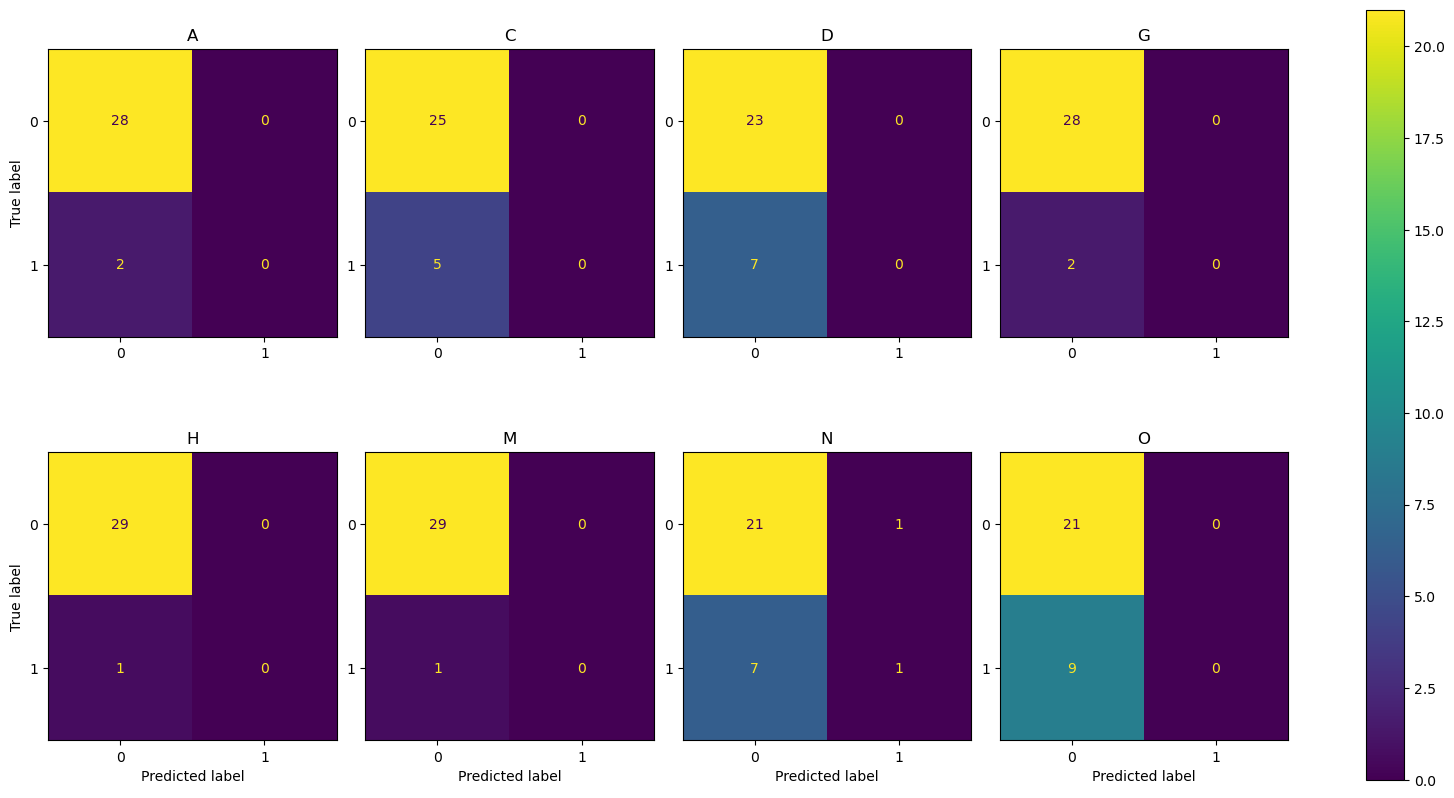

In [12]:
print(
    f"t_loss: {test_loss:.4f} | "
    f"t_kappa: {kappa:.4f} | "
    f"t_f1: {f1:.4f} | "
    f"t_auc: {auc:.4f} | "
    f"t_final: {final_score:.4f}"
)

print(
    metrics.classification_report(
        all_y,
        all_probs>0.5,
        output_dict=False,
        target_names=label_names,
        zero_division=0
    )
)

# for i in range(len(label_names)):
#     plot_roc_curve(all_y[:, i], all_probs[:, i])

plot_confusion_matrices(all_y, all_probs)

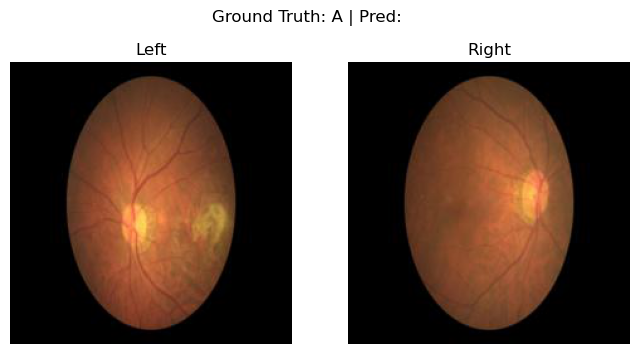

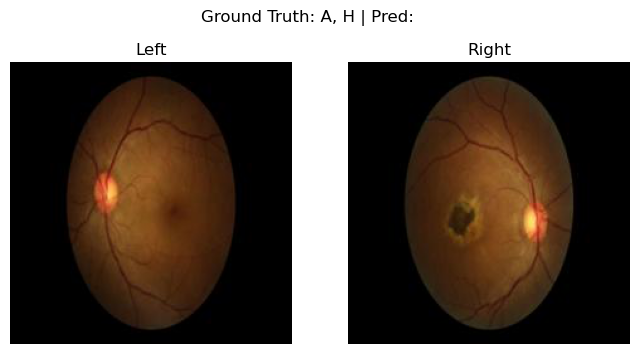

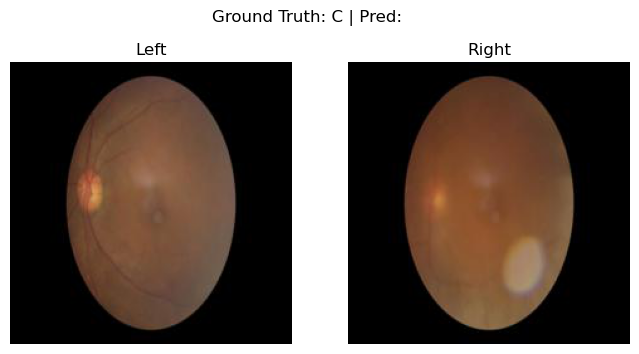

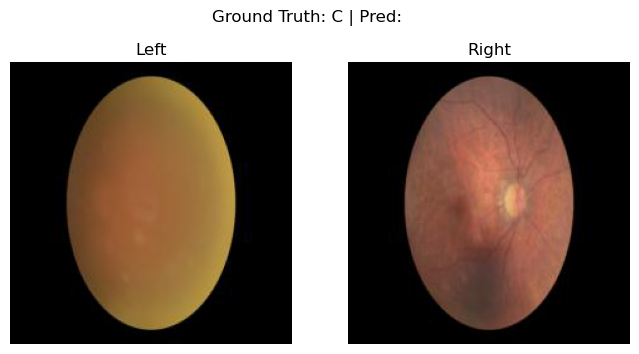

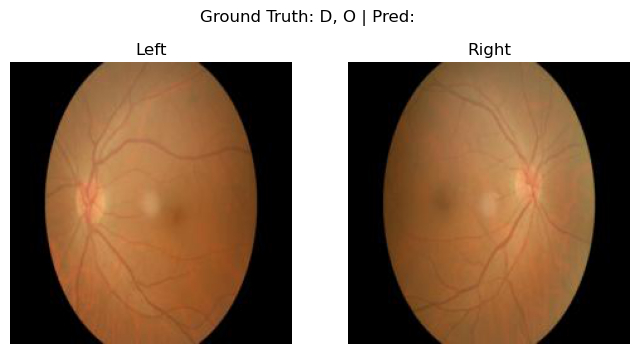

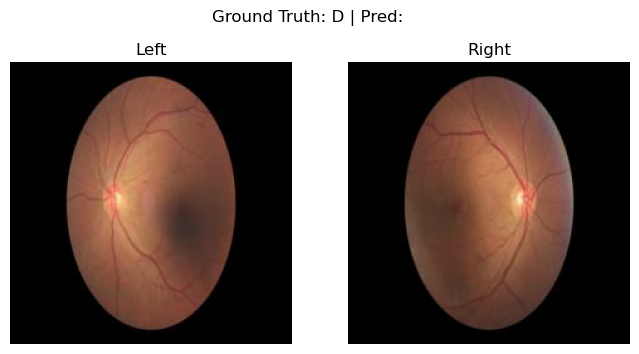

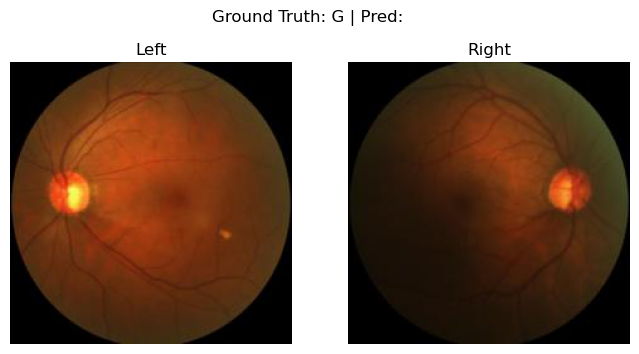

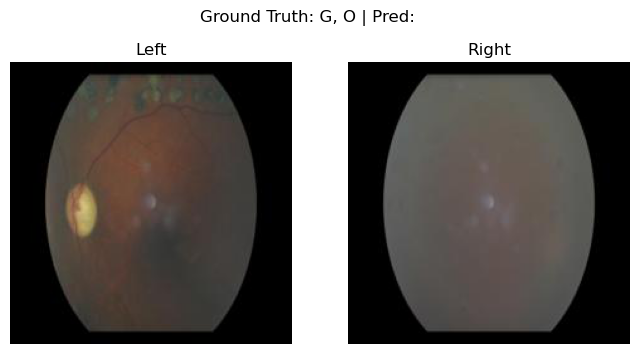

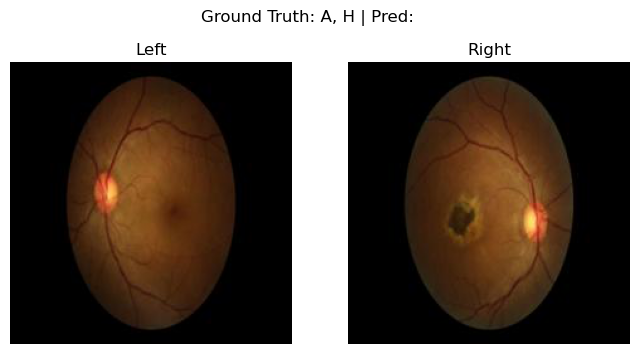

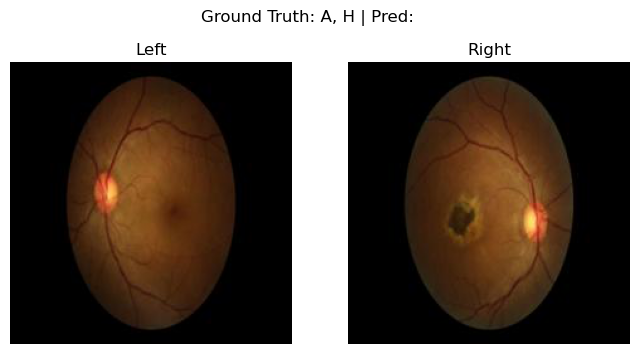

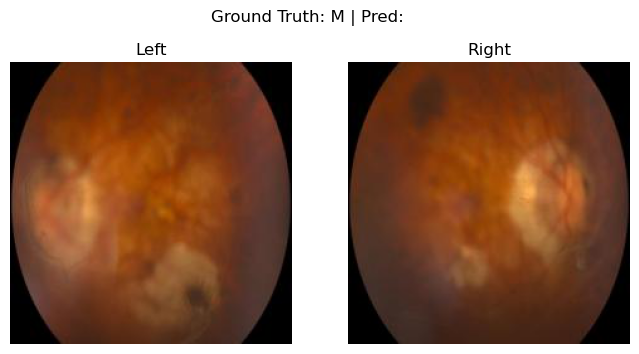

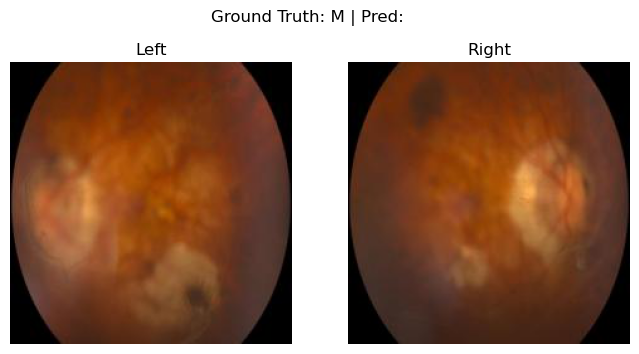

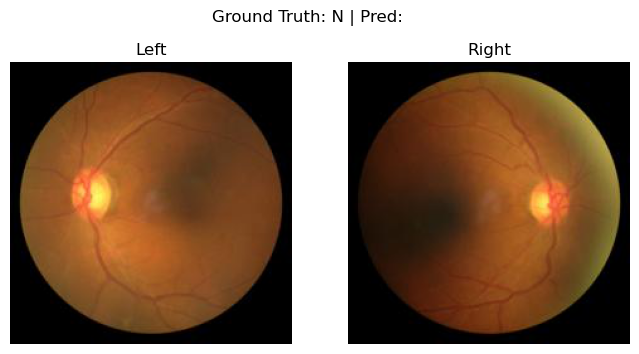

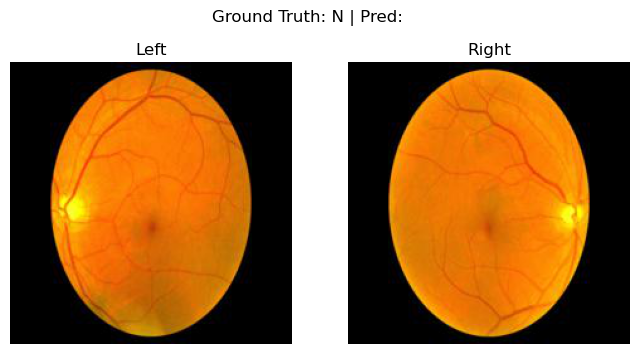

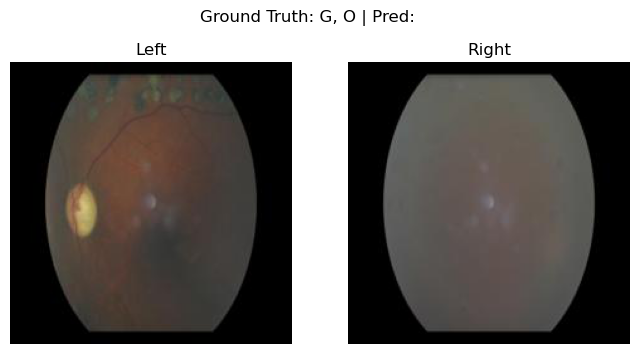

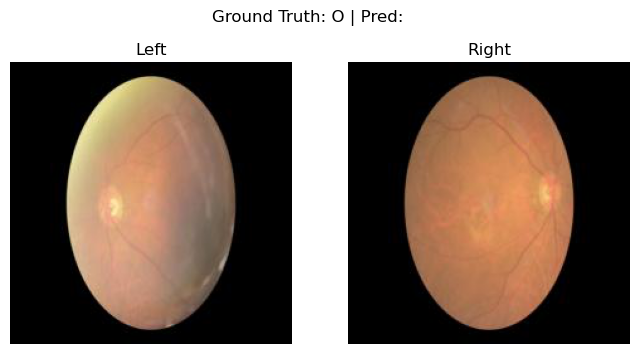

In [115]:
for label in label_names:
    label_df = val_df[val_df[label] == 1].sample(2, replace=True).reset_index(drop=True)
    for i in range(2):
        plt.figure(figsize=(8,4))
        
        left_image_path = f'{images_path}/{label_df.at[i, "Left-Fundus"]}'
        left_img = Image.open(left_image_path)
        plt.subplot(1,2,1)
        plt.imshow(left_img)
        plt.title('Left')
        plt.axis(False)

        right_image_path = f'{images_path}/{label_df.at[i, "Right-Fundus"]}'
        right_img = Image.open(right_image_path)
        plt.subplot(1,2,2)
        plt.imshow(right_img)
        plt.title('Right')
        plt.axis(False)

        gt_labels = label_df.loc[i, ['A','C','D','G','H','M','N','O']].to_numpy()
        gt_labels = mlb.inverse_transform(np.expand_dims(gt_labels, axis=0))
        
        left_img = transform(left_img).unsqueeze(dim=0).to(device)
        right_img = transform(right_img).unsqueeze(dim=0).to(device)
        pred_labels = torch.sigmoid(model(left_img, right_img))>0.5
        pred_labels = mlb.inverse_transform(pred_labels.cpu().numpy())
        
        
        gt_labels = ', '.join(np.squeeze(gt_labels, axis=0))
        pred_labels = ', '.join(np.squeeze(pred_labels, axis=0))
        plt.suptitle(f'Ground Truth: {gt_labels} | Pred: {pred_labels}')